In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sklearn.preprocessing

In [2]:
def data_process(data):
    features = data[:,:-1]
    features = sklearn.preprocessing.StandardScaler().fit_transform(features)
    features = sklearn.preprocessing.normalize(features)
    data[:,:-1] = features
    return data

def accuracy(y, y_pred):
    return sum(y == y_pred)/len(y)

def mc_hinge(W,x,y):

    '''
    w_i - vector of weights of the SVM for the class i; W has |features| rows and |classes| columns
    x - features of a sample
    y - label of a sample
    loss = max{0, max(w_j*x - w_y*x)}, j={0,...,|classes|-1}, j!=y
    output - hingle loss value and the corresponding w_j index
    '''

    n_features, n_class = np.shape(W)
    wyx = W[:,y].dot(x)
    max_dif = - np.inf
    ind_j = 0

    for j in [i for i in range(n_class) if i != y]:
        wjx = W[:,j].dot(x)
        if wjx > max_dif:
            max_dif = wjx
            ind_j = j

    max_dif -= wyx

    if max_dif > 0:
        return 1 + max_dif, ind_j
    else:
        return 0, -1

In [85]:
class LinearSVM:
            
    def fit(self, dataset, learning_rate, epochs, regularization):
        
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        size = len(dataset[0])-1
        n = len(dataset)
        
        w = np.random.rand(size)        
        w_norms = []
        
        X = dataset[:,:-1]
        Y = dataset[:,-1]
        
        for i in range(epochs):
            
            shuffle = np.random.permutation(n)
            X = X[shuffle]
            Y = Y[shuffle]
                        
            for j in range(len(dataset)):

                x = X[j]                
                y = Y[j]
        
                ywx = y * w.dot(x) 
                    
                if ywx < 1:
                    gradient = (2 * regularization * w) / n - y*x
                else:
                    gradient = (2 * regularization * w) / n
                
                w = w - learning_rate * gradient
            
            w_norms.append(np.linalg.norm(w))
        
        return w, w_norms
        
    def predict(self, dataset, w):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)

        y = np.zeros(len(dataset)) 
        dataset = dataset[:,:-1]
        
        for i in range(len(dataset)):
            y[i] = np.sign(np.dot(dataset[i],w))
        return y

In [86]:
class LinearSVM_MC:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization, n_class):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        size = len(dataset[0])-1
        n = len(dataset)
        
        W = np.random.rand(size, n_class)       
        
        # this array stores the W matrix after each epoch
        W_epochs = np.random.rand(epochs, size, n_class)       
        
        w_norms = []

        X = dataset[:,:-1]
        Y = dataset[:,-1]
        
        for i in range(epochs):
            
            shuffle = np.random.permutation(n)
            X = X[shuffle]
            Y = Y[shuffle]
            
            for j in range(len(dataset)):
                x = X[j]                
                y = int(Y[j])
                
                gradient = np.zeros([size, n_class])
        
                temp, k = mc_hinge(W, x, y)
                    
                if temp > 0:
                    
                    gradient[:,y] = -x

                    gradient[:,k] = x
                    
                
                W = W - learning_rate * (gradient + (2 * regularization * W) / n)
                
                
                '''
                W = W - learning_rate * gradient / n
                
                temp = np.linalg.norm(W, ord='fro')
                if temp > 1/regularization:
                    W /= (temp * regularization)
                '''
            W_epochs[i] = W
            w_norms.append(np.linalg.norm(W, axis=0))
            
        w_norms = np.array(w_norms)
        
        return W, W_epochs
        
    def predict(self, dataset, W):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        y = np.zeros(len(dataset)) 
        dataset = dataset[:,:-1]

        for i in range(len(dataset)):
            y[i] = np.argmax(np.dot(W.T, dataset[i]))
        return y
    
    
    def plot_accuracies(self, train_dataset, test_dataset, W_epochs):
        epochs = len(W_epochs)
        test_accuracies = np.zeros(epochs)
        train_accuracies = np.zeros(epochs)
        for i in range(epochs):
            train_labels = self.predict(train_dataset, W_epochs[i])
            test_labels = self.predict(test_dataset, W_epochs[i])
            train_accuracies[i] = accuracy(train_dataset[:,-1], train_labels)
            test_accuracies[i] = accuracy(test_dataset[:,-1], test_labels)
            

        xs = np.array(range(epochs))+1
        fig = plt.figure(figsize=(7,7))
        ax = plt.axes()
        ax.set(xlabel="epochs", ylabel="accuracy")
        line = ax.plot(xs, train_accuracies, marker='.', label='training') #, marker='o'
        line = ax.plot(xs, test_accuracies, marker='.', label='test') #, marker='o'
        ax.legend()
        plt.title("Accuracy over Epochs")
        plt.show()


In [87]:
toydata = pd.read_csv('toydata_large.csv').to_numpy()
toydata = data_process(toydata)

In [88]:
mySVM = LinearSVM()
regularization = 0.01
learning_rate = 0.001
epochs = 10
w, w_norms = mySVM.fit(toydata, learning_rate, epochs, regularization)

In [89]:
labels = mySVM.predict(toydata, w)
accuracy(toydata[:,-1], labels)

1.0

### Multiclass SVM

Import MNIST dataset and prepare the data

In [90]:
data = np.load("mnist.npz")

train = data["train"].T
#train = data_process(train)
train_labels = data["train_labels"][0]

test = data["test"].T
#test = data_process(test)
test_labels = data["test_labels"][0]

mnist_train = np.zeros([len(train), len(train[0])+1])
mnist_train[:,:-1] = train
mnist_train[:,-1] = train_labels

mnist_test = np.zeros([len(test), len(test[0])+1])
mnist_test[:,:-1] = test
mnist_test[:,-1] = test_labels

In [91]:
mySVM2 = LinearSVM_MC()
regularization = 0.1
learning_rate = 0.001
epochs = 15

W, W_epochs = mySVM2.fit(mnist_train, learning_rate, epochs, regularization, n_class=10)

In [92]:
labels = mySVM2.predict(mnist_train, W)
accuracy(mnist_train[:,-1], labels)

0.8664166666666666

In [93]:
labels = mySVM2.predict(mnist_test, W)
accuracy(mnist_test[:,-1], labels)

0.8575

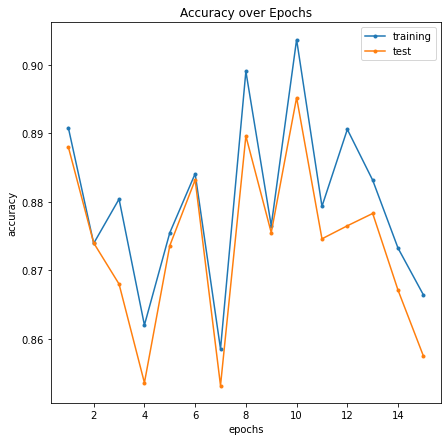

In [94]:
mySVM2.plot_accuracies(mnist_train, mnist_test, W_epochs)